**Imports**

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from src.models import ResNetEncoder, SiameseUNetChangeModel
from src.data import ChangeDetectionDataset


**Loading Dataset**

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
encoder = ResNetEncoder(backbone="resnet50", pretrained=False)

encoder.load_state_dict(
    torch.load("../outputs/encoder_ssl_r50.pth", map_location=device)
)

encoder.eval()
print("Encoder loaded")


/home/dthefather/miniconda3/envs/terrachange/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dthefather/miniconda3/envs/terrachange/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Encoder loaded


In [4]:
model = SiameseUNetChangeModel(encoder).to(device)

model.load_state_dict(
    torch.load("../outputs/change_model.pth", map_location=device)
)

model.eval()
print("Change model loaded:", type(model))


Change model loaded: <class 'src.models.SiameseUNetChangeModel'>


In [5]:
dataset = ChangeDetectionDataset(
    root_dir="../data/raw/levir/val",
    image_size=256
)

print("Dataset size:", len(dataset))


Dataset size: 64


In [6]:
idx = 12

t1, t2, gt = dataset[idx]

print(t1.shape, t2.shape, gt.shape)


torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


In [7]:
with torch.no_grad():
    pred = model(
        t1.unsqueeze(0).to(device),
        t2.unsqueeze(0).to(device)
    )
    pred = F.interpolate(
        pred,
        size=gt.shape[-2:],
        mode="bilinear",
        align_corners=False
    )

    pred_prob = torch.sigmoid(pred)[0,0].cpu()


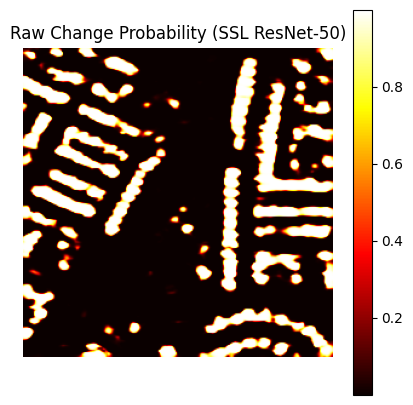

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(pred_prob, cmap="hot")
plt.colorbar()
plt.title("Raw Change Probability (SSL ResNet-50)")
plt.axis("off")
plt.show()


In [9]:
threshold = 0.25   # try 0.2 / 0.25 / 0.3
pred_bin = (pred_prob > threshold).float()


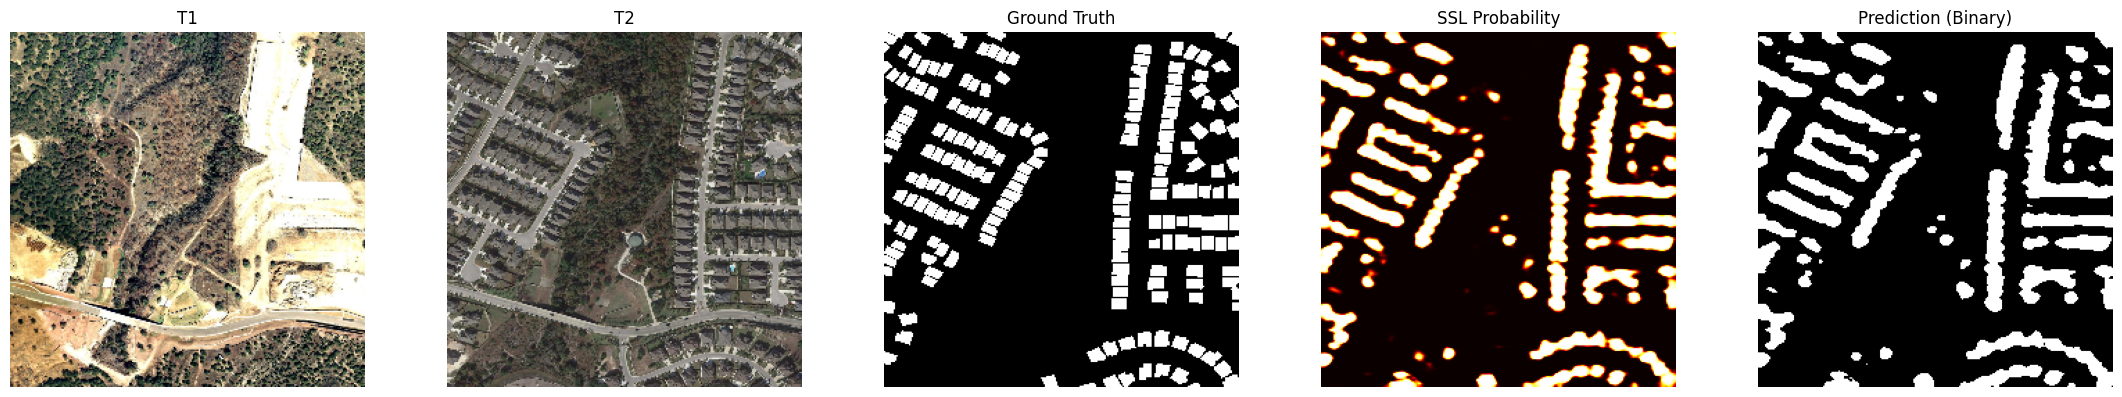

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(22,4))

ax[0].imshow(t1.permute(1,2,0))
ax[0].set_title("T1")

ax[1].imshow(t2.permute(1,2,0))
ax[1].set_title("T2")

ax[2].imshow(gt.squeeze(0), cmap="gray")
ax[2].set_title("Ground Truth")

ax[3].imshow(pred_prob, cmap="hot")
ax[3].set_title("SSL Probability")

ax[4].imshow(pred_bin, cmap="gray")
ax[4].set_title("Prediction (Binary)")

for a in ax:
    a.axis("off")

plt.tight_layout()
plt.show()


In [11]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn.functional as F
from tqdm import tqdm

from src.models import ResNetEncoder, SiameseUNetChangeModel
from src.data import ChangeDetectionDataset



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



encoder = ResNetEncoder(backbone="resnet50", pretrained=False)
encoder.load_state_dict(
    torch.load("../outputs/encoder_ssl_r50.pth", map_location=device)
)
encoder.eval()

model = SiameseUNetChangeModel(encoder).to(device)
model.load_state_dict(
    torch.load("../outputs/change_model.pth", map_location=device)
)
model.eval()

print("Model loaded successfully")


dataset = ChangeDetectionDataset(
    root_dir="../data/raw/levir/test",  # or val
    image_size=256
)

print("Dataset size:", len(dataset))


tp = 0
fp = 0
fn = 0

threshold = 0.25   # IMPORTANT: tuned threshold

with torch.no_grad():
    for i in tqdm(range(len(dataset))):
        t1, t2, gt = dataset[i]

        t1 = t1.unsqueeze(0).to(device)
        t2 = t2.unsqueeze(0).to(device)
        gt = gt.squeeze(0).to(device)   # [H, W]

        pred = model(t1, t2)

        pred = F.interpolate(
            pred,
            size=gt.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        prob = torch.sigmoid(pred)[0,0]
        pred_bin = (prob > threshold).float()

        tp += torch.sum((pred_bin == 1) & (gt == 1)).item()
        fp += torch.sum((pred_bin == 1) & (gt == 0)).item()
        fn += torch.sum((pred_bin == 0) & (gt == 1)).item()



eps = 1e-6

iou = tp / (tp + fp + fn + eps)
precision = tp / (tp + fp + eps)
recall = tp / (tp + fn + eps)
f1 = 2 * precision * recall / (precision + recall + eps)

print("\n===== CHANGE DETECTION METRICS =====")
print(f"IoU       : {iou:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


Using device: cuda
Model loaded successfully
Dataset size: 128


100%|██████████| 128/128 [00:17<00:00,  7.42it/s]


===== CHANGE DETECTION METRICS =====
IoU       : 0.5341
Precision : 0.6916
Recall    : 0.7010
F1-score  : 0.6963


In [12]:
import os
print(os.getcwd())


/home/dthefather/Project/TerraChange/notebooks


In [13]:
import os
import numpy as np
from PIL import Image

from src.data import ChangeDetectionDataset
from utils import load_change_model

DATA_ROOT = "../data/raw/levir/test"  # or "data/test", "data/val", etc.

dataset = ChangeDetectionDataset(DATA_ROOT)
model = load_change_model()

os.makedirs("examples", exist_ok=True)

num_examples = min(3, len(dataset))

for idx in range(num_examples):
    img1, img2, gt = dataset[idx]

    ex_dir = f"examples/ex_{idx+1:02d}"
    os.makedirs(ex_dir, exist_ok=True)

    img1_np = (img1.permute(1,2,0).numpy() * 255).astype(np.uint8)
    img2_np = (img2.permute(1,2,0).numpy() * 255).astype(np.uint8)
    gt_np   = (gt.squeeze().numpy() * 255).astype(np.uint8)

    Image.fromarray(img1_np).save(f"{ex_dir}/t1.png")
    Image.fromarray(img2_np).save(f"{ex_dir}/t2.png")
    Image.fromarray(gt_np).save(f"{ex_dir}/gt.png")

print("✅ Example gallery generated successfully")


✅ Example gallery generated successfully
